In [1]:
import warnings
warnings.filterwarnings("ignore", "in-band")

import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import zuko

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
#from river.data.dataset import #DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *

import sealgw
import lal

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
Nsample = 5
Ntest = 1
injection_parameters_all = generate_BNS_injection_parameters(
        Nsample,
        a_max=0.8,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)

injection_parameters_test = generate_BNS_injection_parameters(
        Ntest,
        a_max=0.8,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)


injection_parameters_all['luminosity_distance'] = np.zeros(Nsample) + 1
injection_parameters_test['luminosity_distance'] = np.zeros(Ntest) + 1

In [121]:
f2=20
f1=100

m=1.
duration = sealgw.simulation.generating_data.tau_of_f(f1,m1=m, m2=m)-sealgw.simulation.generating_data.tau_of_f(f2,m1=m, m2=m)
length = duration*(f2-f1)

print(duration, length)

-272.09049989704596 21767.239991763676


In [3]:
source_type = 'BNS'
detector_names = ['H1']#['H1', 'L1', 'V1'] 
duration = 12000
f_low = 5
f_high = 20

f_ref = 20
sampling_frequency = 64
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'zero_noise' #'zero_noise' bilby_default
use_sealgw_detector = True

In [4]:
data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

data_generator_test = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

03:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
03:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
Using zero_noise PSDs to generate data.


In [5]:
data_generator.inject_signals(injection_parameters_all, Nsample)
data_generator_test.inject_signals(injection_parameters_test, Ntest)

Nneeded not set. Actual number of injection may be less than Ninjection due to SNR threshold. 
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 20.0% done
Injecting 2-th signal, 40.0% done
Injecting 3-th signal, 60.0% done
Injecting 4-th signal, 80.0% done
Nneeded not set. Actual number of injection may be less than Ninjection due to SNR threshold. 
Injecting 0-th signal, 0.0% done


In [13]:
data_generator.data['strains']['H1']

[array([ 2.31843663e-21+7.54885485e-21j, -6.98067106e-21-3.69093662e-21j,
         7.54283501e-21-2.33473447e-21j, ...,
         1.58007014e-21-3.12737448e-22j,  1.59584011e-21-2.18405823e-22j,
         0.00000000e+00+0.00000000e+00j]),
 array([-3.67535062e-21-1.29490510e-20j,  1.09329326e-20-7.84966981e-21j,
         1.10924572e-20+7.61994963e-21j, ...,
        -2.67560581e-21+2.42729965e-22j, -2.68184338e-21+1.59312243e-22j,
         0.00000000e+00+0.00000000e+00j]),
 array([-1.79475534e-21-9.11810795e-21j,  8.59725806e-21+3.52633834e-21j,
        -7.67891529e-21+5.23154509e-21j, ...,
        -7.60850869e-22+1.65097700e-21j, -8.48653927e-22+1.60758901e-21j,
         0.00000000e+00+0.00000000e+00j]),
 array([-8.98815562e-21+1.20287882e-21j,  3.70628843e-21-8.27733117e-21j,
         5.09042067e-21+7.50703017e-21j, ...,
        -1.55190308e-21+8.43222042e-22j, -1.59473728e-21+7.59126707e-22j,
         0.00000000e+00+0.00000000e+00j]),
 array([-1.99083741e-21+6.12265264e-21j, -2.74299865

In [6]:
f = data_generator.frequency_array_masked

#data_generator.generate_waveforms(injection_parameters_all)
data_generator_test.generate_waveforms(injection_parameters_test)
'''
hp = np.array(data_generator.waveforms['waveform_polarizations']['plus']['amplitude']) *\
    np.exp(1j* np.array(data_generator.waveforms['waveform_polarizations']['plus']['phase']))

hc = np.array(data_generator.waveforms['waveform_polarizations']['cross']['amplitude']) *\
    np.exp(1j* np.array(data_generator.waveforms['waveform_polarizations']['cross']['phase']))

h_train = np.vstack([hp,hc])
'''

hp_test = np.array(data_generator_test.waveforms['waveform_polarizations']['plus']['amplitude']) *\
    np.exp(1j* np.array(data_generator_test.waveforms['waveform_polarizations']['plus']['phase']))

hc_test = np.array(data_generator_test.waveforms['waveform_polarizations']['cross']['amplitude']) *\
    np.exp(1j* np.array(data_generator_test.waveforms['waveform_polarizations']['cross']['phase']))

h_tests = np.vstack([hp_test,hc_test])

In [8]:
c = lal.C_SI
pi = np.pi
G = lal.G_SI
gamma = 0.5772

In [29]:
testindex = 0

hh = h_tests[testindex]

mc = injection_parameters_test['chirp_mass'][testindex]
m1 = injection_parameters_test['mass_1'][testindex]
m2 = injection_parameters_test['mass_2'][testindex]
eta = m1*m2/(m1+m2)**2

m = m1+m2
flso = 1/6**1.5/2/pi*c**3/G / lal.MSUN_SI / m


In [10]:
mc, eta

(1.0271941873487744, 0.24998623207698734)

In [14]:
eta = 0.24

In [30]:
#C1 = 0.75 * (8*np.pi * lal.G_SI * lal.MSUN_SI / lal.C_SI**3)**(-5/3)
v = (G*pi*m*lal.MSUN_SI*f/c**3)**(1/3)
vlso = (G*pi*m*lal.MSUN_SI*flso/c**3)**(1/3)
p1 = 3/128/eta/v**5
p2 = p1 * 20/9*(743/336+11/4*eta)*v**2
p3 = p1 * -16*pi * v**3
p4 = p1 * 10*(3058673/1016064 + 5429/1008 * eta + 617/144 * eta**2)*v**4 
p5 = p1 * pi*(38645/756-65/9*eta)*(1+3*np.log(v/vlso))*v**5
p6 = p1 * (11583231236531/4694215680 - 640/3*pi**2 - 6848*gamma/21 - 6848*np.log(4*v)/21 +\
           (-15737765635/3048192 + 2255*pi**2/12)*eta + 76055/1728*eta**2 - 127825/1296*eta**3 ) * v**6
p7 = p1 * pi*(77096675/254016 + 378515/1512*eta - 74045/756*eta**2) * v**7

phase_corr1 = np.exp(-1j * p1)
phase_corr_2PN = np.exp(-1j * (p1+p2+p3+p4))
phase_corr_3p5PN = np.exp(-1j * (p1+p2+p3+p4+p5+p6+p7))
amp_corr = mc**(5/6) * f**(-7/6)

In [31]:
def cancel_phases(h, m1, m2, f):
    c = lal.C_SI
    pi = np.pi
    G = lal.G_SI
    gamma = 0.5772
    
    mc = (m1*m2)**(3/5) / (m1+m2)**(1/5)
    m = m1+m2
    eta = (m1*m2) / (m1+m2)**2
    
    v = (G*pi*m*lal.MSUN_SI*f/c**3)**(1/3)
    flso = 1/6**1.5/2/pi*c**3/G / lal.MSUN_SI / m
    vlso = (G*pi*m*lal.MSUN_SI*flso/c**3)**(1/3)
    

    p1 = 3/128/eta/v**5
    p2 = p1 * 20/9*(743/336+11/4*eta)*v**2
    p3 = p1 * -16*pi * v**3
    p4 = p1 * 10*(3058673/1016064 + 5429/1008 * eta + 617/144 * eta**2)*v**4 
    p5 = p1 * pi*(38645/756-65/9*eta)*(1+3*np.log(v/vlso))*v**5
    p6 = p1 * (11583231236531/4694215680 - 640/3*pi**2 - 6848*gamma/21 - 6848*np.log(4*v)/21 +\
               (-15737765635/3048192 + 2255*pi**2/12)*eta + 76055/1728*eta**2 - 127825/1296*eta**3 ) * v**6
    p7 = p1 * pi*(77096675/254016 + 378515/1512*eta - 74045/756*eta**2) * v**7

    #phase_corr1 = np.exp(-1j * p1)
    #phase_corr_2PN = np.exp(-1j * (p1+p2+p3+p4))
    phase_corr_3p5PN = np.exp(-1j * (p1+p2+p3+p4+p5+p6+p7))
    amp_corr = mc**(5/6) * f**(-7/6)
    
    return h / phase_corr_3p5PN / amp_corr / 10

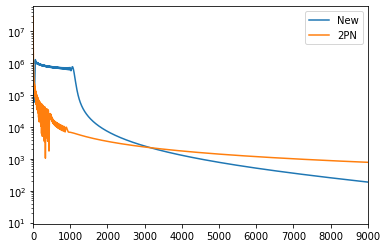

In [36]:
plt.plot(abs(np.fft.fft(np.real(hh / phase_corr1))), label='New')
plt.plot(abs(np.fft.fft(np.real(hh / phase_corr_2PN))), label='2PN')

plt.legend()
plt.xlim(0,9000)
plt.yscale('log')

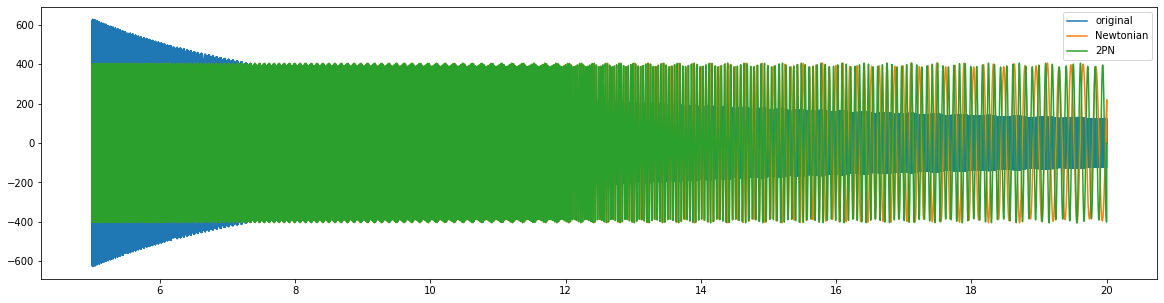

In [19]:
plt.figure(figsize=(20,5))
plt.plot(f, np.real(hh), label='original')
plt.plot(f, np.real(hh / phase_corr1 / amp_corr / 10 ), label='Newtonian')
plt.plot(f, np.real(hh / phase_corr_2PN / amp_corr / 10 ), label='2PN')
#plt.plot(f, np.real(hh / phase_corr_3p5PN / amp_corr / 10 ), label='3.5PN')

plt.legend()
#plt.xlim(10,12)

In [17]:
class WaveformStrecher():
    def __init__(self, farray, interp_method = scipy.interpolate.CubicSpline):
        self.farray = farray 
        self.farray_strech = farray**(-5/3)
        self.farray_strech_resample = np.linspace(min(self.farray_strech), max(self.farray_strech), len(self.farray))
        self.df = self.farray_strech_resample[1] - self.farray_strech_resample[0]
        self.interp_method = interp_method
        
    def strech(self, h):
        h_amp_scaled = h * self.farray**(7/6)
        
        interpolator_real = self.interp_method(self.farray_strech[::-1], h_amp_scaled.real[::-1])
        interpolator_imag = self.interp_method(self.farray_strech[::-1], h_amp_scaled.imag[::-1])
        h_streched = interpolator_real(self.farray_strech_resample) + 1j*interpolator_imag(self.farray_strech_resample)
        
        return h_streched[::-1]
    
    def unstrech(self, h_streched):
        interpolator_real = self.interp_method(self.farray_strech_resample, h_streched.real[::-1])
        interpolator_imag = self.interp_method(self.farray_strech_resample, h_streched.imag[::-1])
        
        h_amp_scaled = interpolator_real(self.farray_strech) + 1j*interpolator_imag(self.farray_strech)
        h = h_amp_scaled / self.farray**(7/6)
        
        return h
        

In [205]:
f.shape

(50001,)

In [127]:
ws = WaveformStrecher(f)
#h_train_streched = np.zeros_like(h_train)
h_tests_streched = np.zeros_like(h_tests)


#for i,h in enumerate(h_train):
#    h_train_streched[i] = ws.strech(h)
    
for i,h in enumerate(h_tests):
    h_tests_streched[i] = ws.strech(h)

In [128]:
fs = ws.farray_strech_resample

In [129]:
h_tests_streched_ffd = np.fft.fft(h_tests_streched, axis=1)

In [130]:
mc_min = bilby.gw.conversion.component_masses_to_chirp_mass(1,1)
mc_max = bilby.gw.conversion.component_masses_to_chirp_mass(3,3)

ffmin = fdsinfreq(mc_max)
ffmax = fdsinfreq(mc_min)

In [131]:
ff = np.fft.fftfreq(h_tests_streched_ffd.shape[1])

In [138]:
h_tests_streched_ffd.shape

(2000, 50001)

In [146]:
maxargs = np.argmax(abs(h_tests_streched_ffd), axis=1)


(2000.0, 20000.0)

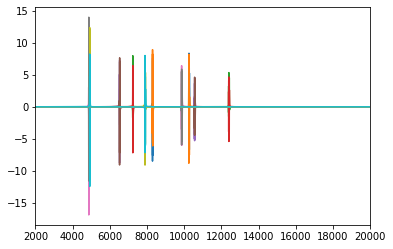

In [133]:
for i in range(10):
    plt.plot(np.real(h_tests_streched_ffd[i]) /1e7)
    plt.plot(np.imag(h_tests_streched_ffd[i]) /1e7)
    
plt.xlim(2000,20000)

(8173.0, 8429.0)

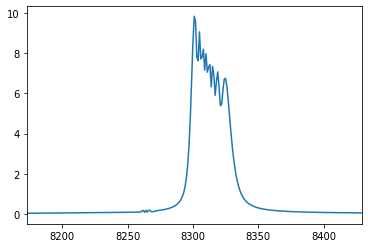

In [151]:
i=5
w = 128
plt.plot(np.abs(h_tests_streched_ffd[i]) /1e7)
plt.xlim(maxargs[i]-w,maxargs[i]+w)

(0.0, 3000.0)

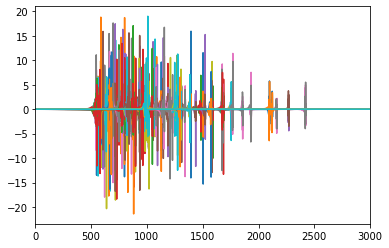

In [79]:
for i in range(100):
    plt.plot(np.real(h_tests_streched_ffd[i]) /1e7)
    plt.plot(np.imag(h_tests_streched_ffd[i]) /1e7)
    
plt.xlim(0,3000)

In [52]:
tt = np.real(h_tests_streched_ffd[0])

ttmax = max(abs(tt))

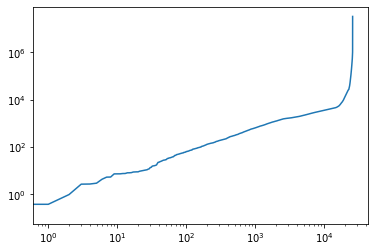

In [58]:
plt.loglog(np.sort(abs(tt)))

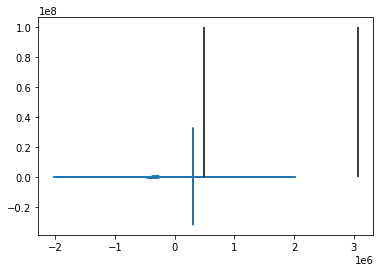

In [44]:
plt.plot(ff / ws.df, np.real(h_tests_streched_ffd[0]))

plt.vlines(x=ffmin, ymin=0, ymax=1e8, color='k')
plt.vlines(x=ffmax, ymin=0, ymax=1e8, color='k')

In [28]:
ffmin

492478.0318668322

# IPCA

In [4]:
n_components=1024
ipca = IncrementalPCA(n_components=n_components)

In [19]:
data_generator.frequency_array_masked

array([ 5.        ,  5.00008333,  5.00016667, ..., 19.99983333,
       19.99991667, 20.        ])

In [28]:
Nsample_template = 2000
Nround = 10 # actual sample of training will be Nsample_template * Nround



for i in range(Nround):
    print(f'round {i}.')
    injection_parameters_template = generate_BNS_injection_parameters(
        Nsample_template,
        a_max=0.8,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)
    injection_parameters_template['luminosity_distance'] = np.zeros(Nsample_template) + 1

    data_generator.inject_signals(injection_parameters_template, 10)

    h_train = np.array(data_generator.data['strains']['H1'])
    
    for j,h in enumerate(h_train):
        m1 = injection_parameters_template['mass_1'][j]
        m2 = injection_parameters_template['mass_2'][j]
        h = cancel_phases(h, m1=m1, m2=m2, f = data_generator.frequency_array_masked)
    ipca.fit(np.real(h_train))
    ipca.fit(np.imag(h_train))
    
    data_generator.initialize_waveforms()
    del h_train
    print(f'round {i} finished.')

round 0.
Nneeded not set. Actual number of injection may be less than Ninjection due to SNR threshold. 


KeyboardInterrupt: 

In [41]:
h_train.shape

(944, 180001)

In [40]:
for j,h in enumerate(h_train):
    print(j)
    m1 = injection_parameters_template['mass_1'][j]
    m2 = injection_parameters_template['mass_2'][j]
    h_train[j] = cancel_phases(h, m1=m1, m2=m2, f = data_generator.frequency_array_masked)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


KeyboardInterrupt: 

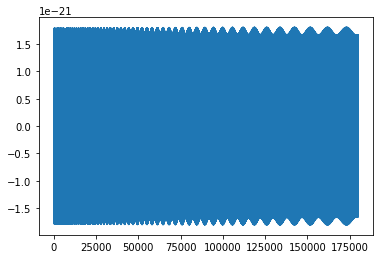

In [38]:
plt.plot(h)

In [37]:
h = cancel_phases(h, m1=m1, m2=m2, f = data_generator.frequency_array_masked)

In [21]:
h.shape

(180001,)

In [22]:
data_generator.frequency_array_masked.shape

(180001,)

In [ ]:
injection_parameters_test = generate_BNS_injection_parameters(
        Ntest,
        a_max=0.8,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)


injection_parameters_test['luminosity_distance'] = np.zeros(Ntest) + 1
data_generator_test.inject_signals(injection_parameters_test, Ntest)
htest = np.array(data_generator_test.data['strains']['H1'])

In [58]:
bb = kpca.inverse_transform(ss)

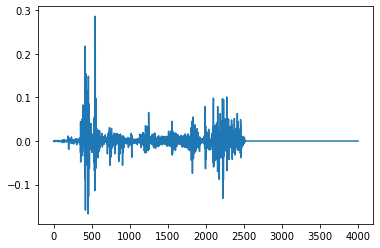

In [59]:
plt.plot(ss[0])


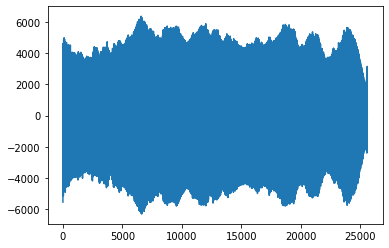

In [63]:
plt.plot(bb[0])


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


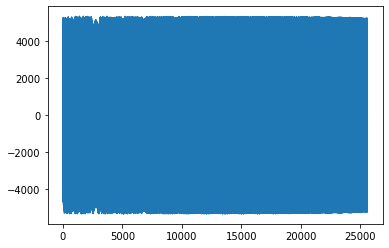

In [64]:
plt.plot(h_tests_streched[0])


# KPCA

In [55]:
n_components=8192
kpca = KernelPCA(n_components=n_components, kernel='cosine', fit_inverse_transform=True, eigen_solver='randomized')

In [56]:
Nsample_template = 2000
Nround = 10 # actual sample of training will be Nsample_template * Nround



for i in range(Nround):
    print(f'round {i}.')
    injection_parameters_template = generate_BNS_injection_parameters(
        Nsample_template,
        a_max=0.1,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = True)


    data_generator.generate_waveforms(injection_parameters_template)
    hp = np.array(data_generator.waveforms['waveform_polarizations']['plus']['amplitude']) *\
        np.exp(1j* np.array(data_generator.waveforms['waveform_polarizations']['plus']['phase']))

    hc = np.array(data_generator.waveforms['waveform_polarizations']['cross']['amplitude']) *\
        np.exp(1j* np.array(data_generator.waveforms['waveform_polarizations']['cross']['phase']))

    h_train = np.vstack([hp,hc])
    h_train_streched = np.zeros_like(h_train)

    for ii,h in enumerate(h_train):
        h_train_streched[ii] = ws.strech(h)

    
    kpca.fit(np.real(h_train_streched))
    kpca.fit(np.imag(h_train_streched))
    
    data_generator.initialize_waveforms()
    del h_train,hp,hc
    print(f'round {i} finished.')

round 0.
round 0 finished.
round 1.
round 1 finished.
round 2.
round 2 finished.
round 3.
round 3 finished.
round 4.
round 4 finished.
round 5.
round 5 finished.
round 6.
round 6 finished.
round 7.
round 7 finished.
round 8.
round 8 finished.
round 9.
round 9 finished.


In [65]:
ss = kpca.transform(h_train_streched[:3].real)

NameError: name 'h_train_streched' is not defined

In [58]:
bb = kpca.inverse_transform(ss)

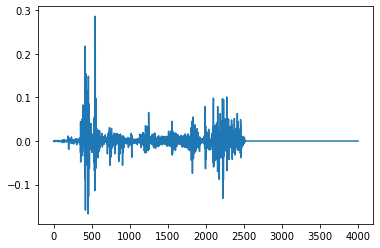

In [59]:
plt.plot(ss[0])


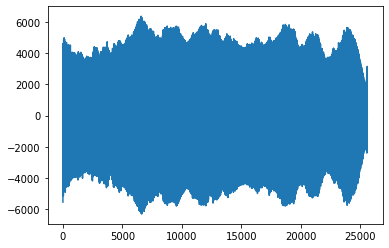

In [63]:
plt.plot(bb[0])


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


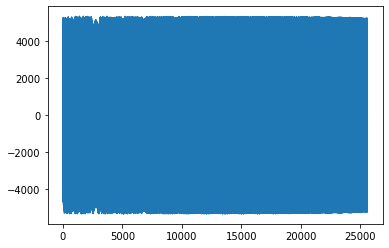

In [64]:
plt.plot(h_tests_streched[0])


In [62]:
h_tests_streched[0]-bb[0]

array([  860.78787363+2577.68055882j, -1248.44270802-1633.12336365j,
       -2676.95425172-4550.19724062j, ..., -6400.27511995 +365.96060657j,
       -5023.96064519-1389.40544348j,     0.           +0.j        ])

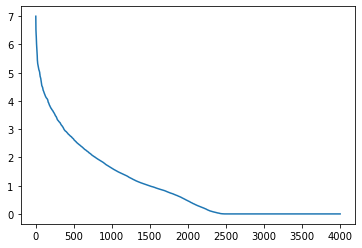

In [61]:
plt.plot(kpca.eigenvalues_)

In [13]:
n=128

#U, s, Vh = randomized_svd(h_train_streched, n)
#V = Vh.T.conj()

In [18]:
mc_min = bilby.gw.conversion.component_masses_to_chirp_mass(1,1)
mc_max = bilby.gw.conversion.component_masses_to_chirp_mass(3,3)

In [24]:
def fdsinfreq(mc):
    C = 0.75 * (8*np.pi * lal.G_SI * lal.MSUN_SI / lal.C_SI**3)**(-5/3)
    return C * mc**(-5/3)

def fisco(mtot):
    return 2200 / mtot


class FourierBases():
    def __init__(self, farray, fmin, fmax, Nbases):
        self.farray = farray
        self.df = farray[1] - farray[0]
        self.fmin = fmin
        self.fmax = fmax
        self.Nbases = Nbases
        
        self.bases_freq = np.linspace(self.fmin, self.fmax, self.Nbases).reshape((Nbases,1))
        self.bases = np.exp(1j* self.bases_freq * self.farray)
    
    def project(self, h):
        coeff = np.dot(self.bases, h) * self.df
        return coeff
    
    def reconstruct(self, coeff):
        dd = np.dot(coeff.real, self.bases.real) + np.dot(coeff.imag, self.bases.imag)
        return dd #self.df#.real + dd.imag

In [160]:
sfmin = fdsinfreq(mc_max)
sfmax = fdsinfreq(mc_min)#/4
Nbases = 200
fb = FourierBases(ws.farray_strech_resample, sfmin, sfmax, Nbases)

In [161]:
hhh = h_tests_streched[0].real
coeff = fb.project(hhh)
recons = fb.reconstruct(coeff)

In [167]:
hhh.shape

(25601,)

In [171]:
sum(fb.bases[1] * hhh) * fb.df

(0.06192668386125123-0.002318445740052611j)

In [164]:
coeff

array([-9.78411433e-03-1.88092589e-02j,  6.19266839e-02-2.31844574e-03j,
       -8.11741313e-03+1.76728254e-02j,  4.30668424e-02+2.62544260e-02j,
       -4.23583176e-02+3.11352051e-02j,  9.18898375e-03+1.45293529e-02j,
       -6.43614905e-02+3.19133787e-03j,  1.01468407e-02-2.32466064e-02j,
       -4.25855184e-02-2.45959824e-02j,  4.62523013e-02-3.45746951e-02j,
       -8.46331345e-03-9.76443157e-03j,  6.65592788e-02-4.23773827e-03j,
       -1.22070482e-02+2.91938881e-02j,  4.17924729e-02+2.25559770e-02j,
       -5.01028071e-02+3.81967387e-02j,  7.59019442e-03+4.48259228e-03j,
       -6.84903620e-02+5.47970952e-03j,  1.42840949e-02-3.55417071e-02j,
       -4.06571284e-02-2.00980803e-02j,  5.38886076e-02-4.20233198e-02j,
       -6.54880090e-03+1.35913621e-03j,  7.01195524e-02-6.94604540e-03j,
       -1.63634554e-02+4.23236229e-02j,  3.91464714e-02+1.71778280e-02j,
       -5.75847491e-02+4.60822828e-02j,  5.31526091e-03-7.81022278e-03j,
       -7.14092344e-02+8.67331706e-03j,  1.84249902

(0.0, 1000.0)

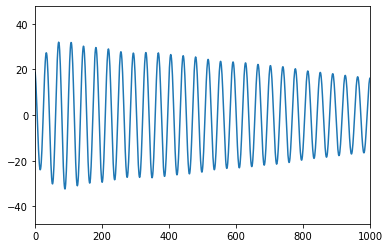

In [162]:
#plt.plot(hhh)
plt.plot(recons)
plt.xlim(0,1000)

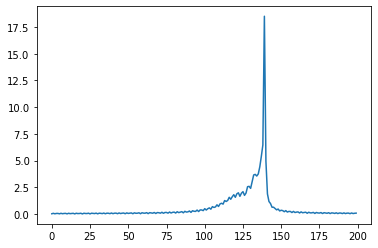

In [163]:
plt.plot(abs(coeff))

(0.0, 0.1)

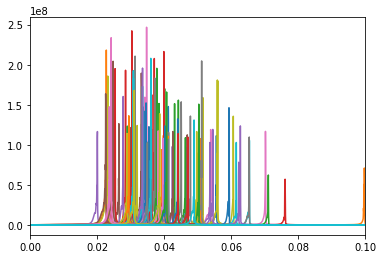

In [44]:
for i in range(100):
    plt.plot(ff, abs(aa[i]))
plt.xlim(0,0.1)

(100.0, 300.0)

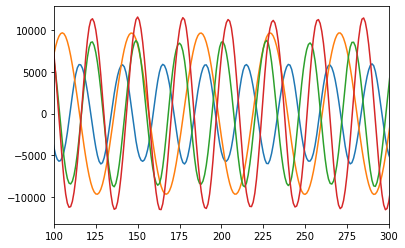

In [27]:
plt.plot(h_tests_streched[0].real)
plt.plot(h_tests_streched[1].real)
plt.plot(h_tests_streched[2].real)
plt.plot(h_tests_streched[3].real)

plt.xlim(100,300)

In [65]:
ws.farray_strech_resample

array([0.00046416, 0.00046441, 0.00046465, ..., 0.00678555, 0.0067858 ,
       0.00678604])

(0.001, 0.0011)

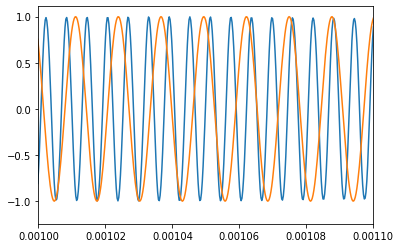

In [77]:
plt.plot(ws.farray_strech_resample, h_tests_streched[0].real/ 6000) 
#plt.plot(ws.farray_strech_resample, np.sin(ws.farray_strech_resample*C * mc_min**(-5/3)))
plt.plot(ws.farray_strech_resample, np.sin(ws.farray_strech_resample*C * mc_max**(-5/3)))

plt.xlim(0.001,0.0011)

In [22]:
mismatches = []

increment = 8
mm_lowthre = 1e-30
ntests = np.append(np.arange(increment, n, increment), n)
for ntest in ntests:
    mismatch_n = []
    for h_test in h_tests_streched:
        h_compressed = h_test @ V[:, :ntest] #np.dot(h_test , V)
        h_decomp = h_compressed @ Vh[:ntest] #np.dot(h_compressed , Vh)
    
        norm1 = np.sqrt(np.sum(np.abs(h_test) ** 2))
        norm2 = np.sqrt(np.sum(np.abs(h_decomp) ** 2))
        inner = np.sum(h_test.conj() * h_decomp).real
        mismatch = 1 - inner / (norm1 * norm2)
        if mismatch<mm_lowthre:
            mismatch_n.append(mm_lowthre)
        else:
            mismatch_n.append(mismatch)
    mismatches.append(mismatch_n)

mismatches = np.array(mismatches)
logMM = np.log10(mismatches)

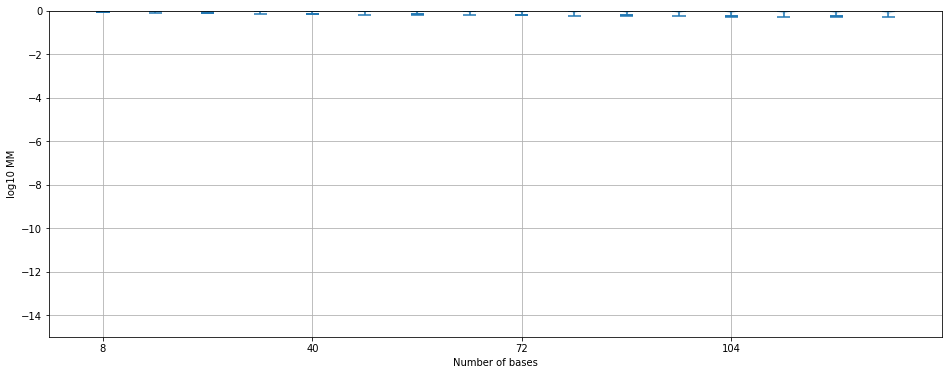

In [23]:
plt.figure(figsize=(16,6))


_ = plt.violinplot(logMM.T, quantiles=np.tile([0.01,0.99], logMM.shape[0]).reshape(2, logMM.shape[0]))

plt.ylabel('log10 MM')
plt.xlabel('Number of bases')

plt.xticks(np.arange(0,len(ntests),4)+1, labels=ntests[::4])

plt.grid()
#plt.savefig(f'outputs/mm_vs_nbasis_{f_low}Hz{f_high}Hz{duration}s.png')

#plt.xscale('log')
plt.ylim(-15,0)
plt.show()